In [127]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
# TODO
# - add date stamp to all plot file names

import datetime as dt


today = dt.date.today().strftime('%Y-%m-%d')
print(today)


2024-08-14


## IMPORTS

In [129]:
from hdbscan import HDBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import json

from hdbscan.prediction import  all_points_membership_vectors


# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

from matplotlib.colors import LinearSegmentedColormap


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [130]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

## LOAD DATA

In [131]:
# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-08-04"

In [132]:
# input and output paths
from pathlib import Path

# ftrs = 353
ftrs = 375

p = Path('/Users/david/projects/lc2-1028/')
dfile = p / f"1028-features-{ftrs}-{today}.arrow"

sample_label_file = p / "1028-sample-labels.arrow"


figdir    = p / str(ftrs)
reportdir = "../lc2-report"
data_dir  = "../lc-1028"

In [133]:
# timestamp for saving figures

import datetime as dt

timestamp = dt.datetime.now().strftime("%Y-%m-%d")

# check to see if there is a subdirectory in figdir for the timestamp
import os

if not os.path.exists(os.path.join(figdir, timestamp)):
    os.makedirs(os.path.join(figdir, timestamp))

# redirect output to figdir/timestamp

figdir = Path(os.path.join(figdir, timestamp))

print(figdir)

/Users/david/projects/lc2-1028/375/2024-08-14


In [134]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset


sample_labels = Dataset.load_from_disk(str(sample_label_file))

# load the dataset from disk
ds_all = Dataset.load_from_disk(str(dfile))
ds     = Dataset.load_from_disk(str(dfile))

In [135]:
sl_df = sample_labels.to_pandas()
sl_df = sl_df.drop(columns = ["__index_level_0__"]) # type: ignore

In [136]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [137]:
try:
    df = df.drop(columns = ["__index_level_0__"])
except KeyError:
    pass
df.shape

(1028, 375)

In [138]:
# # find all columns that start with MED
# med_cols = [col for col in df.columns if col.startswith("MED")]
# med_cols

In [139]:
# import good feature names
feature_map_df = pd.read_csv("./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

103 features loaded.
90 colours loaded.


In [140]:
# cc.glasbey_hv[106:108]


## LC+, LC-, HC

### Select which sets of features to use

In [141]:
LC_pos = df.query('LC_STATUS == 1').copy() # type: ignore
# LC_neg = df.query('LC_STATUS == 0').copy() # type: ignore 
# HC     = df.query('LC_STATUS == 2').copy()     # type: ignore

In [142]:
LC_pos.shape

(494, 375)

In [143]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except KeyError:
    pass
LC_pos

sex   age  dag  SYMPT-abdominal_pain___1  SYMPT-abdominal_pain___2  \
0    1.0  47.0  1.0                       0.0                       1.0   
1    2.0  37.0  1.0                       0.0                       0.0   
2    2.0  54.0  1.0                       0.0                       0.0   
3    1.0  78.0  1.0                       0.0                       0.0   
4    2.0  33.0  1.0                       0.0                       0.0   
..   ...   ...  ...                       ...                       ...   
978  1.0  25.0  5.0                       0.0                       0.0   
979  1.0  51.0  5.0                       0.0                       0.0   
980  1.0  50.0  5.0                       0.0                       0.0   
981  1.0  71.0  4.0                       0.0                       0.0   
982  2.0  68.0  4.0                       0.0                       0.0   

     SYMPT-chest_pain___1  SYMPT-chest_pain___2  \
0                     0.0                   0.0   
1                     0.0                   0.0   
2                     0.0                   0.0   
3                     0.0                   0.0   
4                     1.0                   0.0   
..                    ...                   ...   
978                   1.0                   0.0   
979                   0.0                   0.0   
980                   1.0                   1.0   
981                   0.0                   0.0   
982                   0.0                   0.0   

     SYMPT-confusion_altered_mental_s___1  \
0                                     0.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   
..                                    ...   
978                                   0.0   
979                                   0.0   
980                                   0.0   
981                                   0.0   
982                                   0.0   

     SYMPT-confusion_altered_mental_s___2  SYMPT-cough___1  ...  \
0                                     1.0              1.0  ...   
1                                     0.0              1.0  ...   
2                                     1.0              1.0  ...   
3                                     0.0              0.0  ...   
4                                     1.0              1.0  ...   
..                                    ...              ...  ...   
978                                   0.0              1.0  ...   
979                                   0.0              0.0  ...   
980                                   0.0              1.0  ...   
981                                   0.0              0.0  ...   
982                                   0.0              0.0  ...   

     MED-Dermatological-agents  MED-Gastrointestinal-agents  \
0                            0                            1   
1                            0                            0   
2                            0                            0   
3                            0                            1   
4                            0                            0   
..                         ...                          ...   
978                          0                            0   
979                          0                            0   
980                          0                            0   
981                          0                            0   
982                          0                            0   

     MED-Hormonal-agents-(sex-hormones)  MED-Hormonal-agents-(thyroid)  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              1   
3                                     0                              0   
4                 

In [144]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 20
VAX 1
HHX 49
IMG 0
LAB 0
SUBS 0


# CLUSTERING

In [145]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [146]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


# drop dag
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'dag').columns)

# drop columns that start with CD and end with ___1
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD.*___1').columns)


# cdrop cols of type object
LC_pos_ = LC_pos_.select_dtypes(exclude = ['object'])



print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(494, 174)
(494, 174)


In [147]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
new_and_worse = lc_symptoms

In [148]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)

In [149]:
LC_pos_.columns

Index(['CD-acute_kidney_injury___2', 'CD-acute_respiratory_distress___2',
       'CD-anemia___2', 'CD-anxiety___2', 'CD-asthma___2', 'CD-avpu',
       'CD-baby_covid', 'CD-bacterial_viral_or_cryptog___2',
       'CD-bacteriemia___2', 'CD-bmi',
       ...
       'SYMPT-seizure___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-skin_rash___2', 'SYMPT-sore_throat___2',
       'SYMPT-trouble_speaking_aphasia_d___2', 'SYMPT-weight_loss___2',
       'SYMPT-wheezing_or_stridor___2', 'VAX-vaccinated', 'age', 'sex'],
      dtype='object', length=174)

In [150]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except KeyError:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_)     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

In [151]:
X.shape

(494, 174)

In [152]:
sites = df["dag"].apply(lambda x: site_name_dict[x])


# use only the sites with indices in the LC_pos_ dataframe
sites = sites.loc[LC_pos_.index]
sites.shape


(494,)

## Use UMAP to visualize the data and cluster

### Handling missing values

In [153]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 1)

print(X.shape)

(494, 159)


### EMBED and CLUSTER

In [154]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
                # 'metric': 'hamming',
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
points   = pipe["embed"].embedding_ # type: ignore
clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels


plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = [c+1 for c in clusters]
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# plot_df, cluster_labels = make_plot_df(pipe, 
#                                         sites,
#                                         site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, spread=5.0, verbose=True)
Wed Aug 14 12:32:14 2024 Construct fuzzy simplicial set
Wed Aug 14 12:32:14 2024 Finding Nearest Neighbors
Wed Aug 14 12:32:14 2024 Finished Nearest Neighbor Search
Wed Aug 14 12:32:14 2024 Construct embedding


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 14 12:32:15 2024 Finished embedding


In [155]:
plot_df

x          y  Cluster  Cluster Confidence Site
0   -11.340892   9.693447        5            0.000000  LDN
1    -4.905222   0.300044        4            0.000000  LDN
2    -5.012092  16.516722        1            0.000000  LDN
3     8.550085  12.469810        2            0.940697  LDN
4    -4.014303  10.030358        4            1.000000  LDN
..         ...        ...      ...                 ...  ...
978  14.660732  12.907857        2            1.000000  LUS
979   7.358306   9.509048        2            0.000000  LUS
980   5.061853  10.869988        2            0.000000  LUS
981  12.308512  13.964569        2            1.000000  RIO
982  -4.575456   0.569463        4            0.000000  RIO

[494 rows x 5 columns]

In [156]:
# add the sample labels to the plot_df
# plot_df = pd.concat([plot_df, sl_df], axis = 1)

# join sl_df to plot_df
plot_df = plot_df.join(sl_df, how = "inner")



plot_df

x          y  Cluster  Cluster Confidence Site Sample_Label_ID
0   -11.340892   9.693447        5            0.000000  LDN        LDN-0001
1    -4.905222   0.300044        4            0.000000  LDN        LDN-0002
2    -5.012092  16.516722        1            0.000000  LDN        LDN-0003
3     8.550085  12.469810        2            0.940697  LDN        LDN-0004
4    -4.014303  10.030358        4            1.000000  LDN        LDN-0005
..         ...        ...      ...                 ...  ...             ...
978  14.660732  12.907857        2            1.000000  LUS        LUS-0353
979   7.358306   9.509048        2            0.000000  LUS        LUS-0174
980   5.061853  10.869988        2            0.000000  LUS        LUS-0319
981  12.308512  13.964569        2            1.000000  RIO        RIO-0074
982  -4.575456   0.569463        4            0.000000  RIO        RIO-0100

[494 rows x 6 columns]

In [157]:
# prepare to export the plot_df

# make a copy that excludes x and y
plot_df2 = plot_df.drop(columns = ["x", "y", "Cluster Confidence"])

# save as an excel fdile

fn = figdir / f"lc-1028-clusters-with-sample-label-id-{timestamp}.xlsx"

plot_df2.to_excel(figdir / fn)

In [158]:
plot_df2

Cluster Site Sample_Label_ID
0          5  LDN        LDN-0001
1          4  LDN        LDN-0002
2          1  LDN        LDN-0003
3          2  LDN        LDN-0004
4          4  LDN        LDN-0005
..       ...  ...             ...
978        2  LUS        LUS-0353
979        2  LUS        LUS-0174
980        2  LUS        LUS-0319
981        2  RIO        RIO-0074
982        4  RIO        RIO-0100

[494 rows x 3 columns]

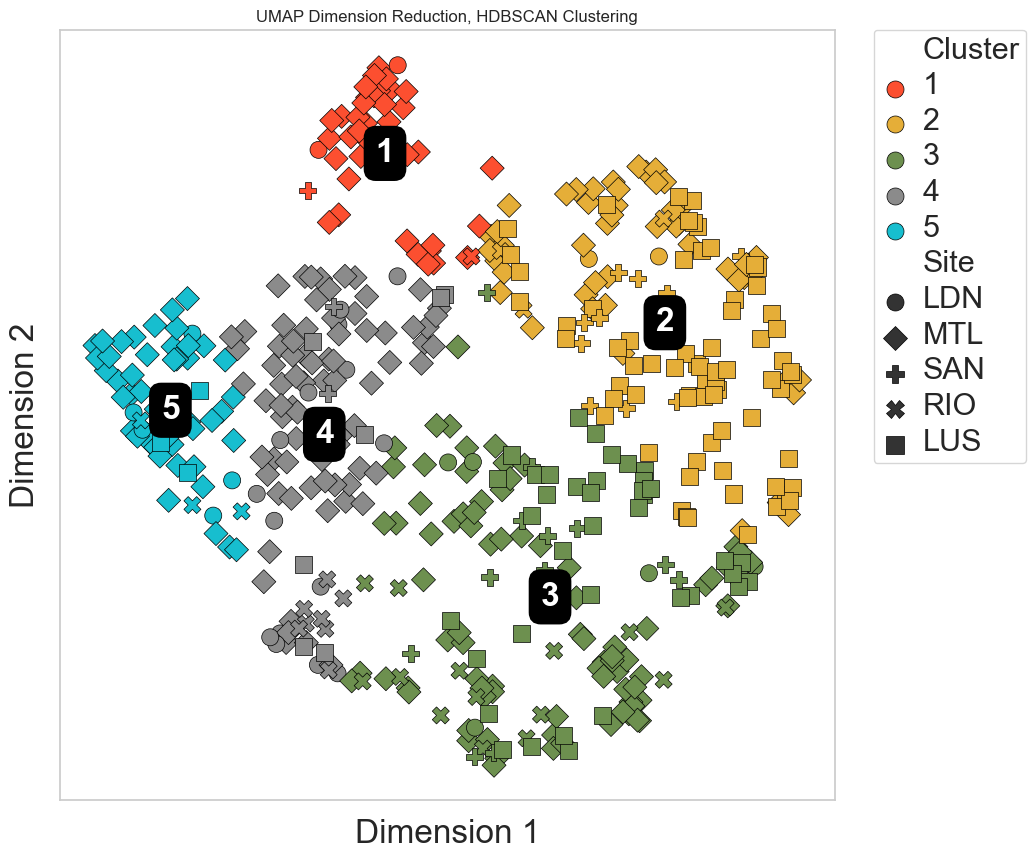

In [159]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = "UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

#### Cluster by Site

In [160]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster     1     2     3     4     5
Site                                 
LDN       2.0   2.0   5.0  15.0   5.0
MTL      39.0  48.0  82.0  76.0  48.0
SAN       1.0  10.0  13.0   2.0   0.0
RIO       1.0   3.0  14.0   8.0   3.0
LUS       0.0  69.0  38.0   7.0   3.0


In [161]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [162]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5
Site                                                     
LDN      0.046512  0.015152  0.032895  0.138889  0.084746
MTL      0.906977  0.363636  0.539474  0.703704  0.813559
SAN      0.023256  0.075758  0.085526  0.018519  0.000000
RIO      0.023256  0.022727  0.092105  0.074074  0.050847
LUS      0.000000  0.522727  0.250000  0.064815  0.050847

#### RFC Model to identify features that differentiate clusters

In [163]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 90
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100


BorutaPy finished running.

Iteration: 	35 / 100
Confirmed: 	27
Tentative: 	0
Rejected: 	132


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=106,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x313DF8F40),
         n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x313DF8F40, verbose=1)

In [164]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=106, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x313DF8F40)

In [165]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


In [166]:
features20

Feature  Importance  \
0                       LC+ Dyspnea    1.000000   
1                               Sex    0.807174   
2                       LC+ Fatigue    0.443259   
3                  PMHx Hypothyroid    0.378943   
4                         LC+ Cough    0.250872   
5                               Age    0.217780   
6                        PMHx Other    0.178358   
7                     PMHx HIV-AIDS    0.122795   
8                  PMHx Anti-Virals    0.121624   
9                    LC+ Arthralgia    0.100652   
10                      LC+ Myalgia    0.099051   
11                     LC+ Headache    0.089462   
12  LC+ Extremity Weakness/Numbness    0.087906   
13                   LC+ Rhinorrhea    0.086866   
14                         PMHx MSK    0.085375   
15                    LC+ Dizziness    0.083809   
16                   LC+ Chest Pain    0.079003   
17              LC+ Ageusia/Anosmia    0.067770   
18                      PMHx Asthma    0.061136   
19        LC+ Altered Mental Status    0.058505   

                             OLD Feature                          Colour  
0   SYMPT-shortness_of_breath_dyspne___2   [0.32549, 0.270588, 0.545098]  
1                                    sex       [0.580392, 0.0, 0.960784]  
2                      SYMPT-fatigue___2  [0.392157, 0.266667, 0.380392]  
3                         HHX-OTHER-hypo  [0.015686, 0.890196, 0.784314]  
4                        SYMPT-cough___2            [0.0, 0.4, 0.470588]  
5                                    age   [0.564706, 0.619608, 0.74902]  
6                              HHX-Other            [1.0, 1.0, 0.603922]  
7                        HHX-HIV or AIDS  [0.643137, 0.152941, 0.129412]  
8                         MED-Antivirals        [0.0, 0.52549, 0.486275]  
9        SYMPT-joint_pain_arthralgia___2       [0.807843, 0.521569, 1.0]  
10        SYMPT-muscle_aches_myalgia___2       [0.584314, 0.827451, 1.0]  
11                    SYMPT-headache___2  [0.921569, 0.815686, 0.607843]  
12  SYMPT-extremity_weakness_or_numb___2            [0.866667, 0.0, 1.0]  
13       SYMPT-runny_nose_rhinorrhea___2       [0.113725, 0.894118, 1.0]  
14                         HHX-OTHER-MSK  [0.482353, 0.294118, 0.568627]  
15                   SYMPT-dizziness___2  [0.784314, 0.509804, 0.435294]  
16                  SYMPT-chest_pain___2  [0.678431, 0.545098, 0.694118]  
17  SYMPT-loss_of_taste_lost_of_smel___2  [0.745098, 0.705882, 0.745098]  
18                            HHX-Asthma       [0.721569, 0.0, 0.501961]  
19  SYMPT-confusion_altered_mental_s___2       [0.670588, 0.447059, 0.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-14/lc-1028-cluster-feature-importances-300-2024-08-14.png


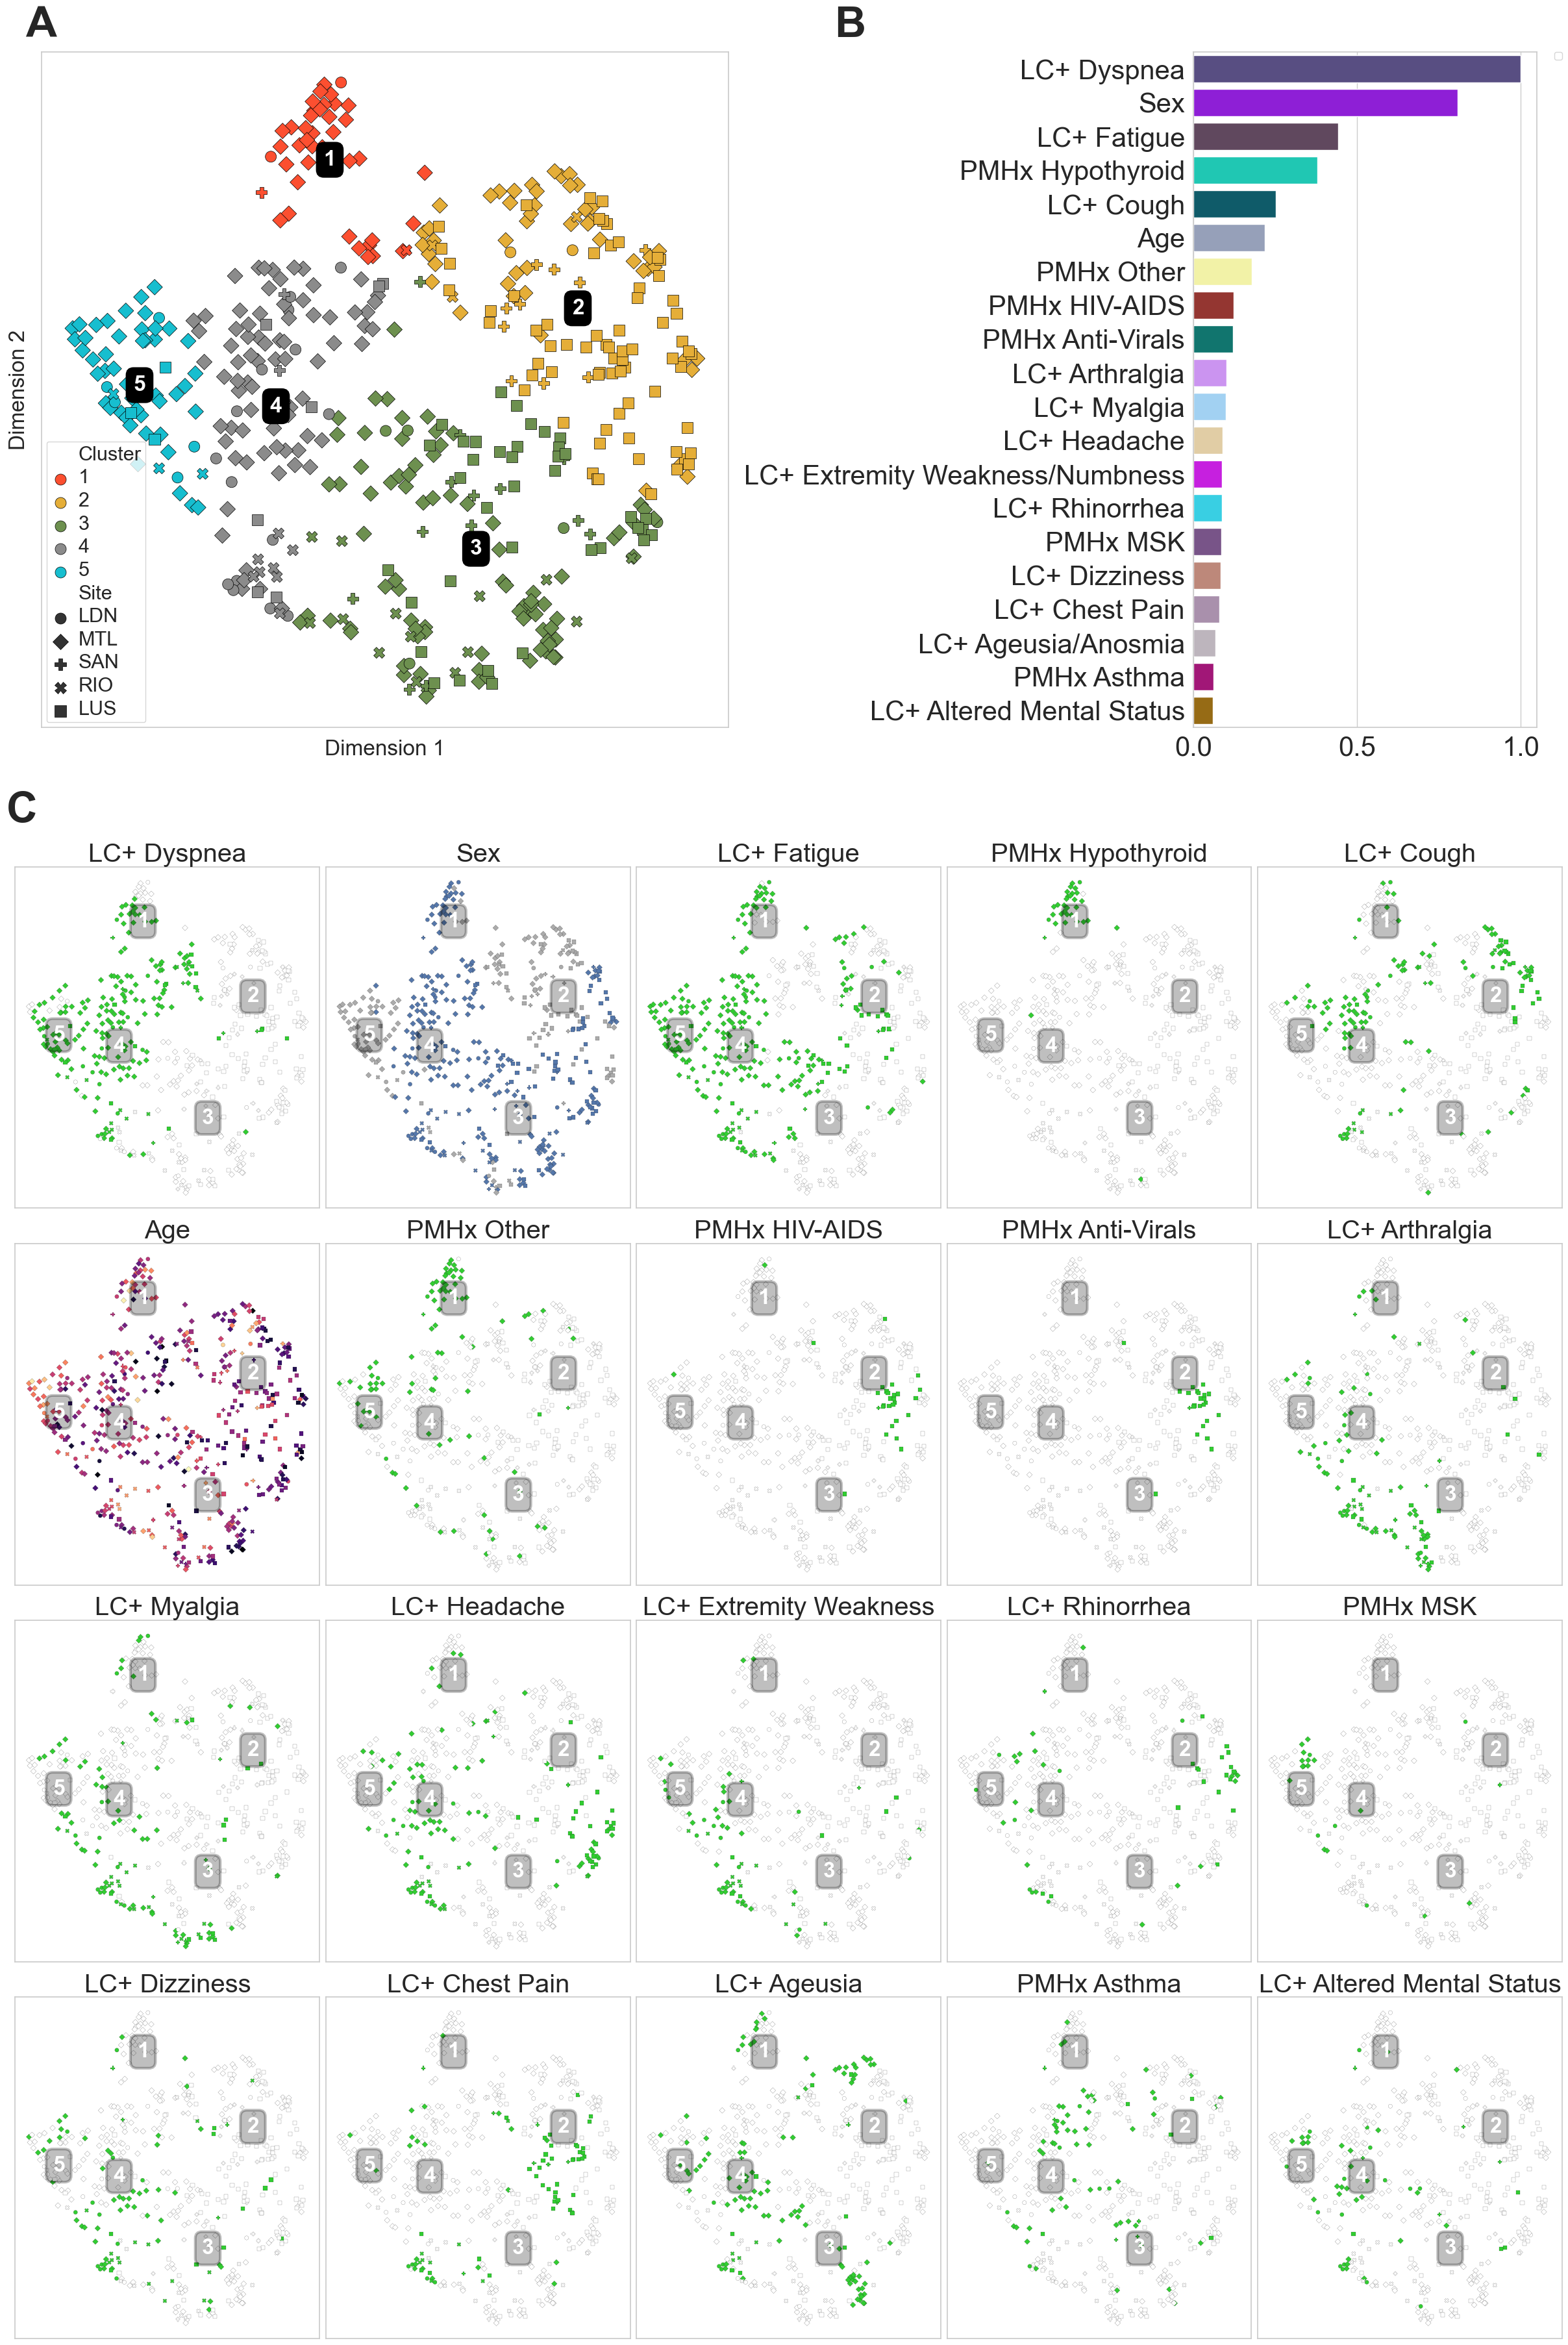

In [167]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.2,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

for dpi in [300]:
    fn = f"{figdir}/lc-1028-cluster-feature-importances-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# if SAVE:
#     # plt.savefig(f"{figdir}/feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
#     plt.savefig(f"{figdir}/feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
#     # plt.savefig(f"{figdir}/feature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
#     # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [168]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"]:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [169]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [170]:
cluster_by_site

Cluster     1     2     3     4     5
Site                                 
LDN       2.0   2.0   5.0  15.0   5.0
MTL      39.0  48.0  82.0  76.0  48.0
SAN       1.0  10.0  13.0   2.0   0.0
RIO       1.0   3.0  14.0   8.0   3.0
LUS       0.0  69.0  38.0   7.0   3.0

In [171]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

cbsm

cluster            1     2     3     4     5
Site                                        
London           6.9   6.9  17.2  51.7  17.2
Montreal        13.3  16.4  28.0  25.9  16.4
San Diego        3.8  38.5  50.0   7.7   0.0
Rio de Janeiro   3.4  10.3  48.3  27.6  10.3
Lusaka           0.0  59.0  32.5   6.0   2.6

In [172]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

In [173]:
zzz

LC+ Dyspnea  LC+ Fatigue  PMHx Hypothyroid  LC+ Cough  PMHx Other  \
cluster                                                                      
1           0.697674     0.604651          0.697674   0.395349    0.790698   
2           0.151515     0.265152          0.000000   0.356061    0.068182   
3           0.072368     0.355263          0.006579   0.078947    0.085526   
4           0.925926     0.888889          0.009259   0.425926    0.129630   
5           0.847458     1.000000          0.000000   0.152542    0.372881   

         PMHx HIV-AIDS  PMHx Anti-Virals  LC+ Arthralgia  LC+ Myalgia  \
cluster                                                                 
1             0.023256          0.000000        0.162791     0.232558   
2             0.196970          0.174242        0.045455     0.060606   
3             0.006579          0.006579        0.243421     0.256579   
4             0.000000          0.000000        0.314815     0.342593   
5             0.016949          0.000000        0.220339     0.288136   

         LC+ Headache  LC+ Extremity Weakness/Numbness  LC+ Rhinorrhea  \
cluster                                                                  
1            0.162791                         0.046512        0.046512   
2            0.189394                         0.030303        0.151515   
3            0.203947                         0.072368        0.026316   
4            0.453704                         0.324074        0.138889   
5            0.186441                         0.186441        0.084746   

         PMHx MSK  LC+ Dizziness  LC+ Chest Pain  LC+ Ageusia/Anosmia  \
cluster                                                                 
1        0.000000       0.093023        0.046512             0.279070   
2        0.015152       0.068182        0.257576             0.151515   
3        0.013158       0.144737        0.131579             0.269737   
4        0.027778       0.351852        0.212963             0.351852   
5        0.237288       0.254237        0.033898             0.169492   

         PMHx Asthma  LC+ Altered Mental Status  
cluster                                          
1           0.186047                   0.069767  
2           0.083333                   0.030303  
3           0.111842                   0.059211  
4           0.287037                   0.240741  
5           0.067797                   0.169492

/Users/david/projects/lc2-1028/375/2024-08-14/lc-1028-feature-prevalence-by-cluster-300-2024-08-14.png


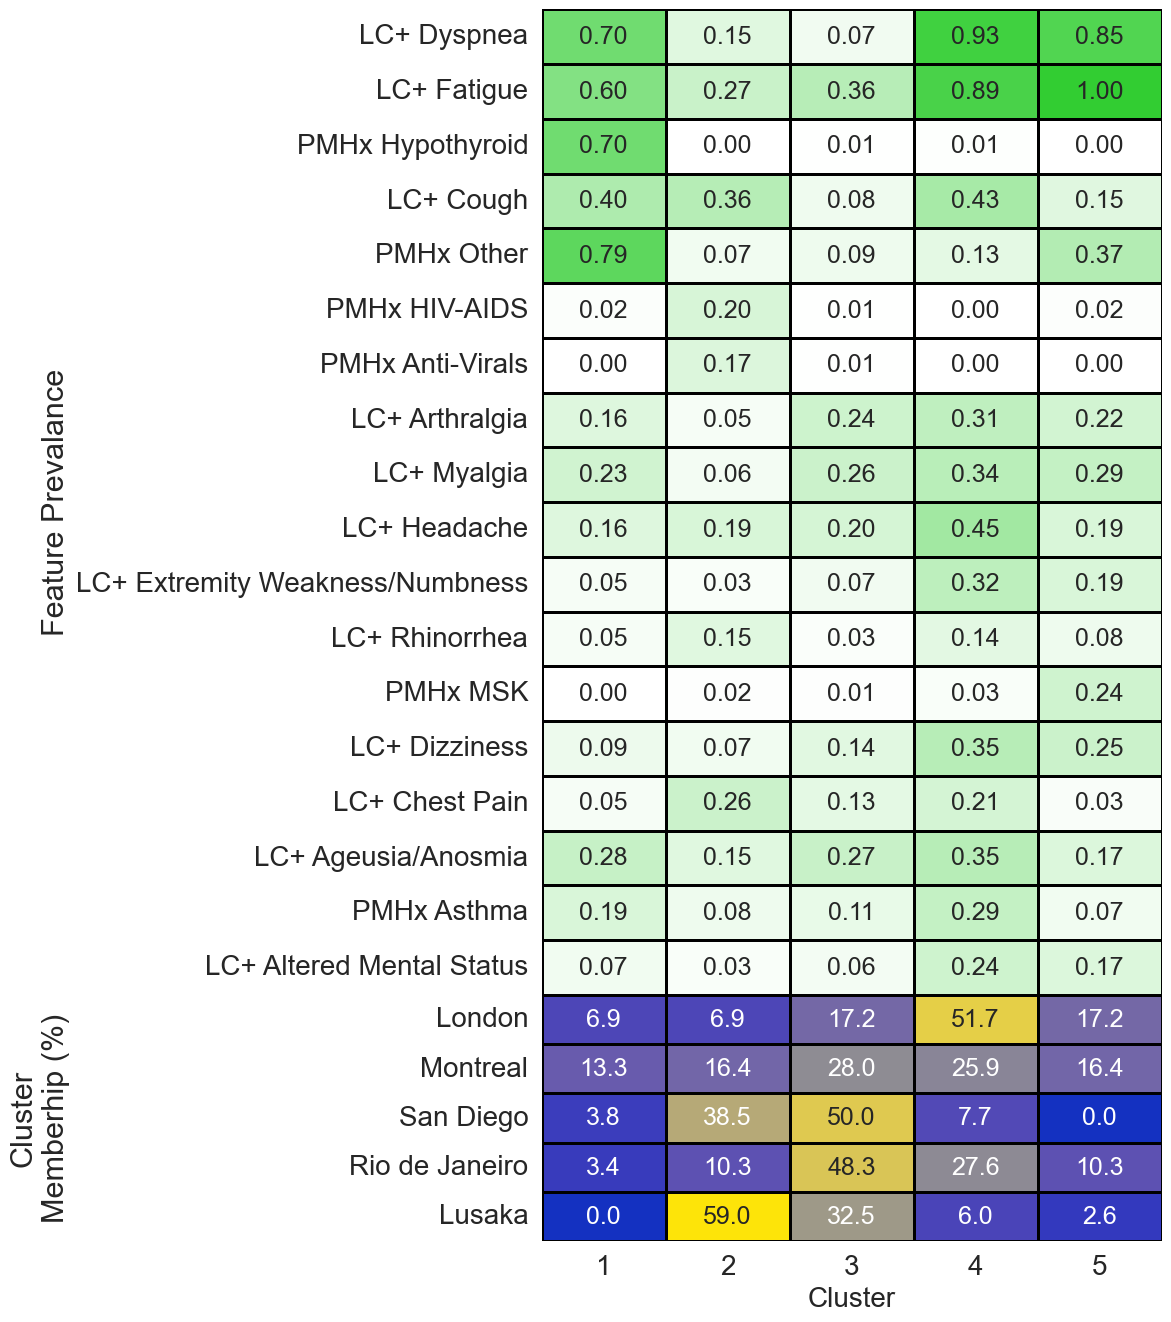

In [174]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([])
axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

for dpi in [300]:
    fn = f"{figdir}/lc-1028-feature-prevalence-by-cluster-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


# By SITE for subphenotypes at each site

In [175]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS

# LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

# LC_pos_["SITE"] = sites

In [176]:
# drop columns with NaNs
LC_pos_.dropna(inplace = True, axis = 1)
LC_pos_.shape

(494, 159)

In [177]:
LC_pos_["SITE"] = sites

In [178]:
# cluster pipeline, iterating over the sites

result_dict = {}

items = site_name_dict.items()

# drop LDN from items
# items = list(items)[1:]

for i, (k,v) in enumerate(items):
    # print(i, k, v)

    print("="*50)
    print(f"Site {k}: {v}")
    print("-"*50)

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE =='{v}'").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])
    the_data = the_data.drop(columns = ["SITE"])

    # print(the_data.shape)

    X = scaler.fit_transform(the_data)     # type: ignore
    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    print(f"Min cluster size = {min_cluster_size}")

    # min_cluster_size = 5


    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': 1,
                    # 'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    # 'spread':       5.0,
                    # 'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)


    # get the plot dataframe and cluster labels
    # sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites.loc[X.index], site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 80
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]

    print(f"Important features: {important_features}")

    if len(important_features) == 0:
        print("No important features found.")
        continue


    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
--------------------------------------------------
Data shape = (29, 158)
X shape    = (29, 158)
Min cluster size = 5
Important features: Index(['HHX-Asthma', 'HHX-OTHER-MSK', 'HHX-Obesity', 'HHX-Psychiatric disease',
       'MED-Analgesics', 'MED-Antidepressants', 'MED-Cardiovascular-agents',
       'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(sex-hormones)',
       'MED-Respiratory-tract-agents', 'SYMPT-abdominal_pain___2',
       'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___2',
       'SYMPT-cough___2', 'SYMPT-dizziness___2', 'SYMPT-headache___2',
       'SYMPT-joint_pain_arthralgia___2', 'SYMPT-loss_of_appetite___2',
       'SYMPT-loss_of_taste_lost_of_smel___2',
       'SYMPT-muscle_aches_myalgia___2', 'SYMPT-nausea_vomiting___2',
       'SYMPT-night_sweats___2', 'SYMPT-shortness_of_breath_dyspne___2',
       'SYMPT-sore_throat___2', 'SYMPT-trouble_speaking_aphasia_d___2', 'sex'],
      dtype='object')
Site 2: MTL
--------------------------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-14/lc-1028-subphenotypes-by-site-300-2024-08-14.png


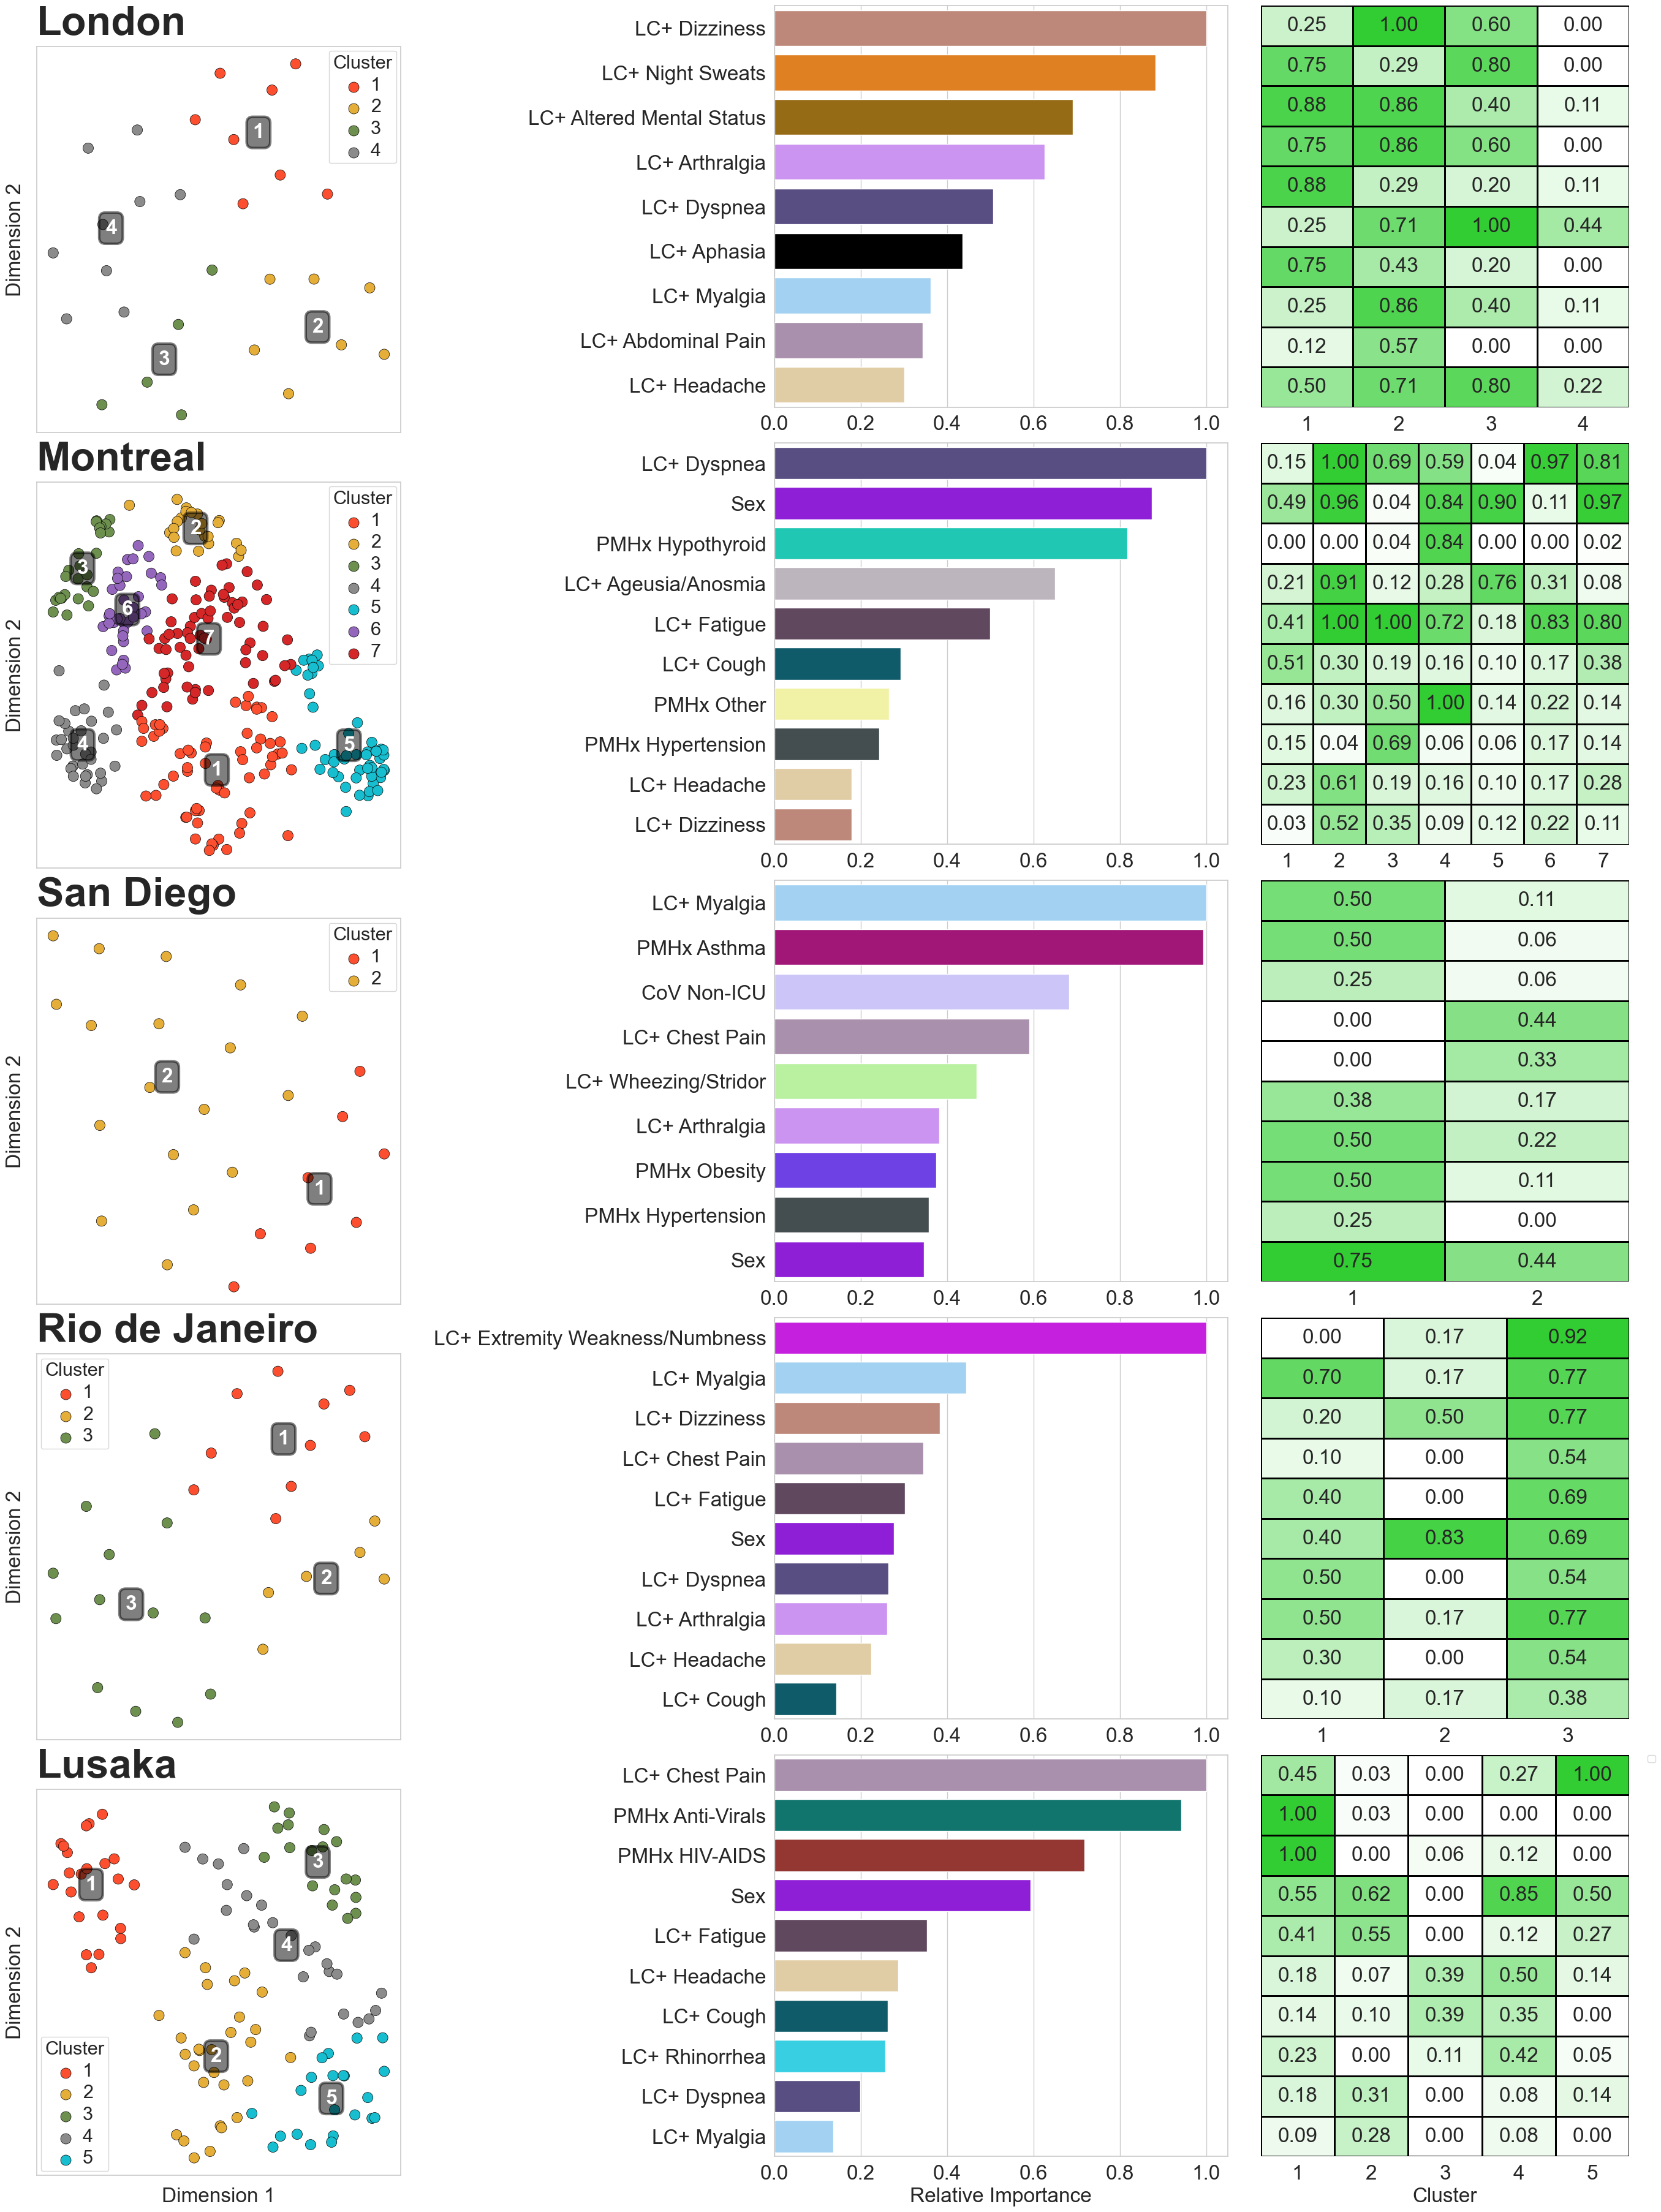

In [179]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None,
                  centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": True},
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

for dpi in [300]:
    fn = f"{figdir}/lc-1028-subphenotypes-by-site-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-300.png", dpi = 300, bbox_inches = 'tight')
# plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-600.png", dpi = 600, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [180]:
# for controlling minimum cluster size
factor = 2

In [181]:
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

# add age and sex to the list
lc_symptoms = lc_symptoms + ["age"] + ["sex"]

In [182]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(494, 30)
(494, 30)
(494, 30)


In [183]:
# drop certain features

# drop features that contain adjunctive
X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# drop features that contain "medication_received"
X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# drop features that contain "type_of_care"
X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# drop features that contain "ventilatory_support_type"
# X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

print(X.shape)

(494, 30)


In [184]:
# scale the features using minmax scaler
X = scaler.fit_transform(X)

In [185]:
# cluster pipeline


min_cluster_size = int(np.sqrt(X.shape[0]))*factor

print(f"MCS = {min_cluster_size}")



hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      1,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                # 'spread':       1.0,
                'random_state': 42,
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
# sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

n_clust = max(cluster_labels)+1

MCS = 44
UMAP(random_state=42, verbose=True)
Wed Aug 14 12:33:32 2024 Construct fuzzy simplicial set
Wed Aug 14 12:33:32 2024 Finding Nearest Neighbors
Wed Aug 14 12:33:32 2024 Finished Nearest Neighbor Search
Wed Aug 14 12:33:32 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 14 12:33:33 2024 Finished embedding


In [186]:
plot_df

x         y  Cluster  Cluster Confidence Site
0     9.486613  4.589602        5            1.000000  LDN
1     9.502893  5.014088        5            1.000000  LDN
2     9.721850  5.846581        5            1.000000  LDN
3     7.928185  8.278749        3            1.000000  LDN
4    10.222098  3.785359        4            1.000000  LDN
..         ...       ...      ...                 ...  ...
978   4.486193  6.538751        2            0.656504  LUS
979   6.632411  7.002454        3            0.983147  LUS
980   5.600737  8.565126        2            1.000000  LUS
981   7.334238  8.894589        2            1.000000  RIO
982   9.627645  4.797679        5            1.000000  RIO

[494 rows x 5 columns]

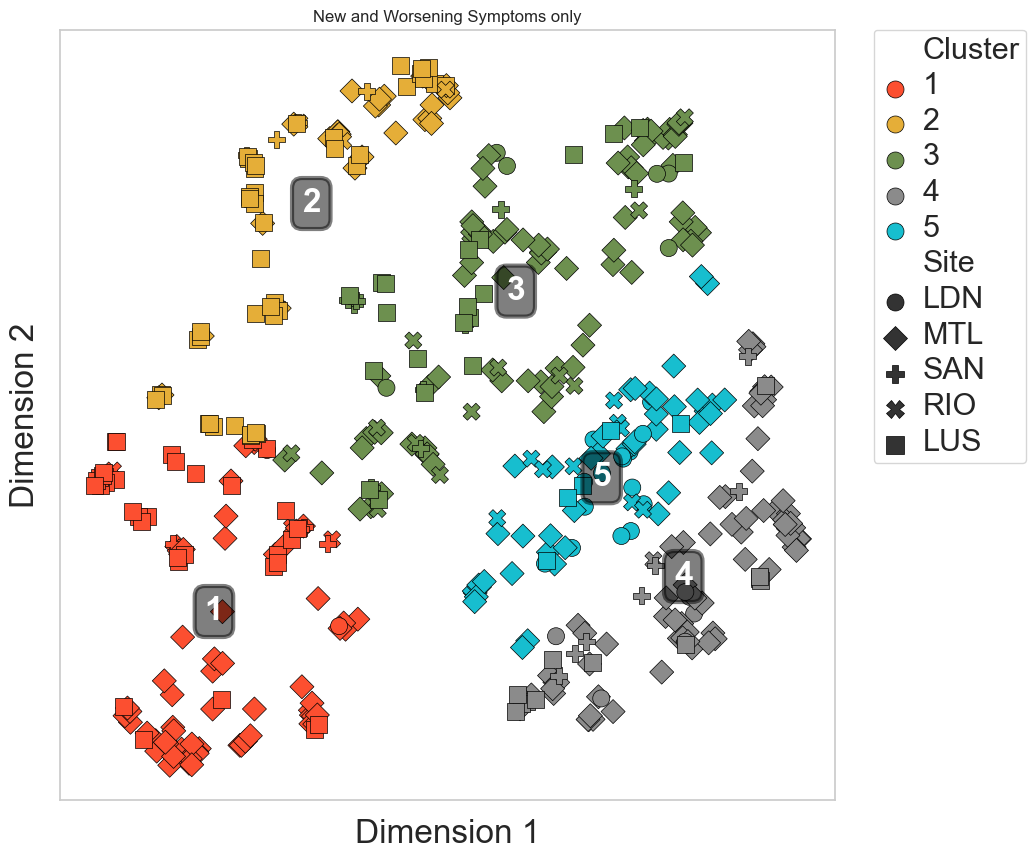

In [187]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = "New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": True},)


In [188]:
# prepare to export the plot_df

# join sl_df to plot_df
plot_df = plot_df.join(sl_df, how = "inner")

# make a copy that excludes x and y
plot_df2 = plot_df.drop(columns = ["x", "y", "Cluster Confidence"])

# save as an excel fdile
plot_df2.to_excel(figdir / f"lc-1028-SYMPT-clusters-with-sample-label-id-{timestamp}.xlsx")

In [189]:
plot_df

x         y  Cluster  Cluster Confidence Site Sample_Label_ID
0     9.486613  4.589602        5            1.000000  LDN        LDN-0001
1     9.502893  5.014088        5            1.000000  LDN        LDN-0002
2     9.721850  5.846581        5            1.000000  LDN        LDN-0003
3     7.928185  8.278749        3            1.000000  LDN        LDN-0004
4    10.222098  3.785359        4            1.000000  LDN        LDN-0005
..         ...       ...      ...                 ...  ...             ...
978   4.486193  6.538751        2            0.656504  LUS        LUS-0353
979   6.632411  7.002454        3            0.983147  LUS        LUS-0174
980   5.600737  8.565126        2            1.000000  LUS        LUS-0319
981   7.334238  8.894589        2            1.000000  RIO        RIO-0074
982   9.627645  4.797679        5            1.000000  RIO        RIO-0100

[494 rows x 6 columns]

In [190]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

In [191]:
# # sort by order in site_name_dict
# cbs = cbs.loc[site_name_dict.values()]

# # rename index values using site_fullname_dict
# cbs.index = cbs.index.map(site_fullname_dict)
# cbs = cbs.astype(int)

# cbs.to_latex(f"{reportdir}/SYMPT_2-cluster-by-site-{n_clust}.tex")

In [192]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

# sort by the order in site_name_dict
cbsm = cbsm.loc[site_fullname_dict.values()]

cbsm

cluster            1     2     3     4     5
Site                                        
London           6.9   0.0  20.7  20.7  51.7
Montreal        21.5   9.6  28.3  25.3  15.4
San Diego       19.2  15.4  38.5  26.9   0.0
Rio de Janeiro  13.8  10.3  41.4   3.4  31.0
Lusaka          29.9  38.5  17.1  10.3   4.3

In [193]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 80
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

RandomForestClassifier(max_depth=7, n_estimators=72, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x382BE3D40)

In [194]:
# dataframes with the feature importance and topN features

topN = 10

fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, topN, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/david/projects/lc2-1028/375/2024-08-14/lc-1028-SYMPT-feature-importances-by-cluster-5-300-2024-08-14.png


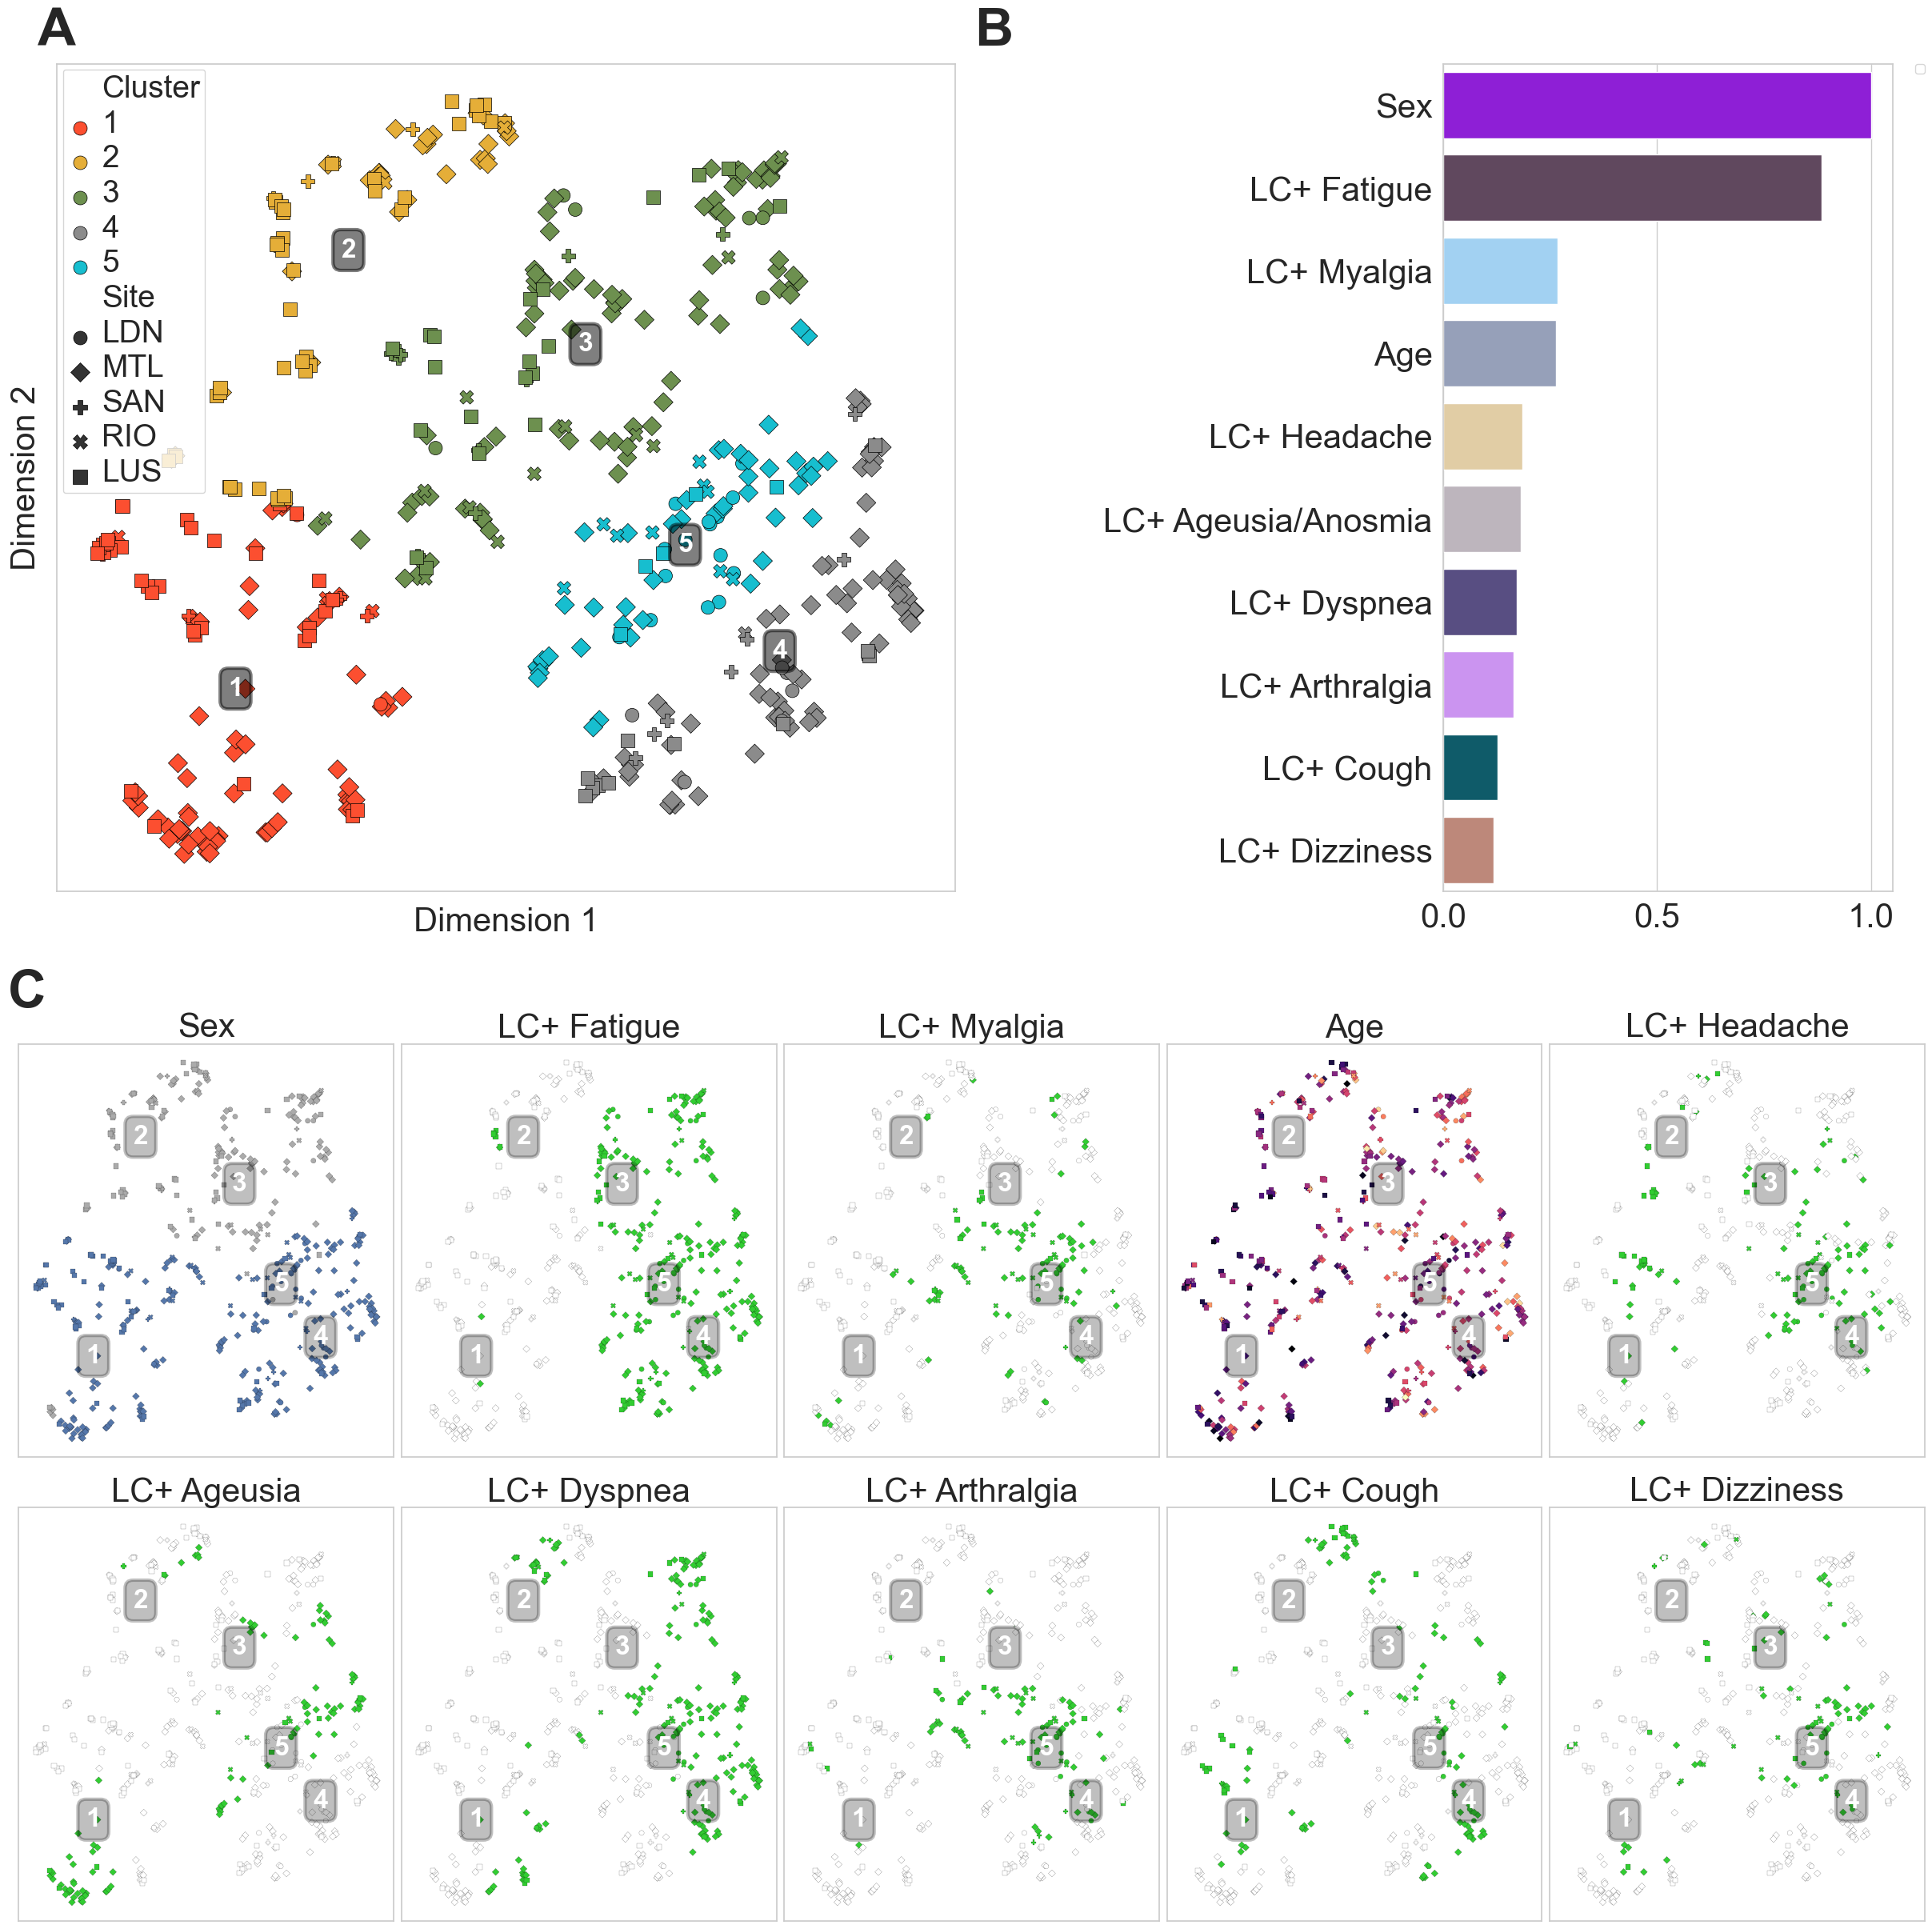

In [195]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# if n_rows == 1:
#     ht_ratio = 0.5
#     ht = 24
# else:
#     ht_ratio = 2
#     ht = 36

ht = 24
ht_ratio = 2

height_ratios = [1,1]

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,ht))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=height_ratios, hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.25,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df[:topN], 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        # show_centroids = False,
                        fontsize = int(FONTSIZE*1.25),

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

for dpi in [300]:
    fn = f"{figdir}/lc-1028-SYMPT-feature-importances-by-cluster-{n_clust}-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')

# if SAVE:
#     plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-ffeature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

In [196]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]
# M = M.drop(columns = ["Age", "Sex"])

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
# mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)

# remove rows with index ["Age", "Sex"]

# drop a row by index
mfv = mfv.drop(index = ["Age"])
mfv = mfv.drop(index = ["Sex"])


In [197]:
mfv

cluster                                 1       2         3     4         5
LC+ Chest Pain                   0.174312  0.3125  0.038168  0.15  0.229730
LC+ Cough                        0.284404  0.3250  0.145038  0.37  0.243243
LC+ Dizziness                    0.110092  0.0625  0.190840  0.07  0.527027
LC+ Extremity Weakness/Numbness  0.027523  0.0250  0.114504  0.11  0.432432
LC+ Fatigue                      0.018349  0.0875  0.671756  0.99  1.000000
LC+ Headache                     0.137615  0.2875  0.160305  0.14  0.675676
LC+ Arthralgia                   0.036697  0.0125  0.282443  0.17  0.513514
LC+ Ageusia/Anosmia              0.376147  0.1000  0.137405  0.13  0.554054
LC+ Myalgia                      0.055046  0.0375  0.381679  0.08  0.594595
LC+ Dyspnea                      0.201835  0.2875  0.419847  0.70  0.554054

/Users/david/projects/lc2-1028/375/2024-08-14/lc-1028-SYMPT-feature-prevalence-by-cluster-5-300-2024-08-14.png


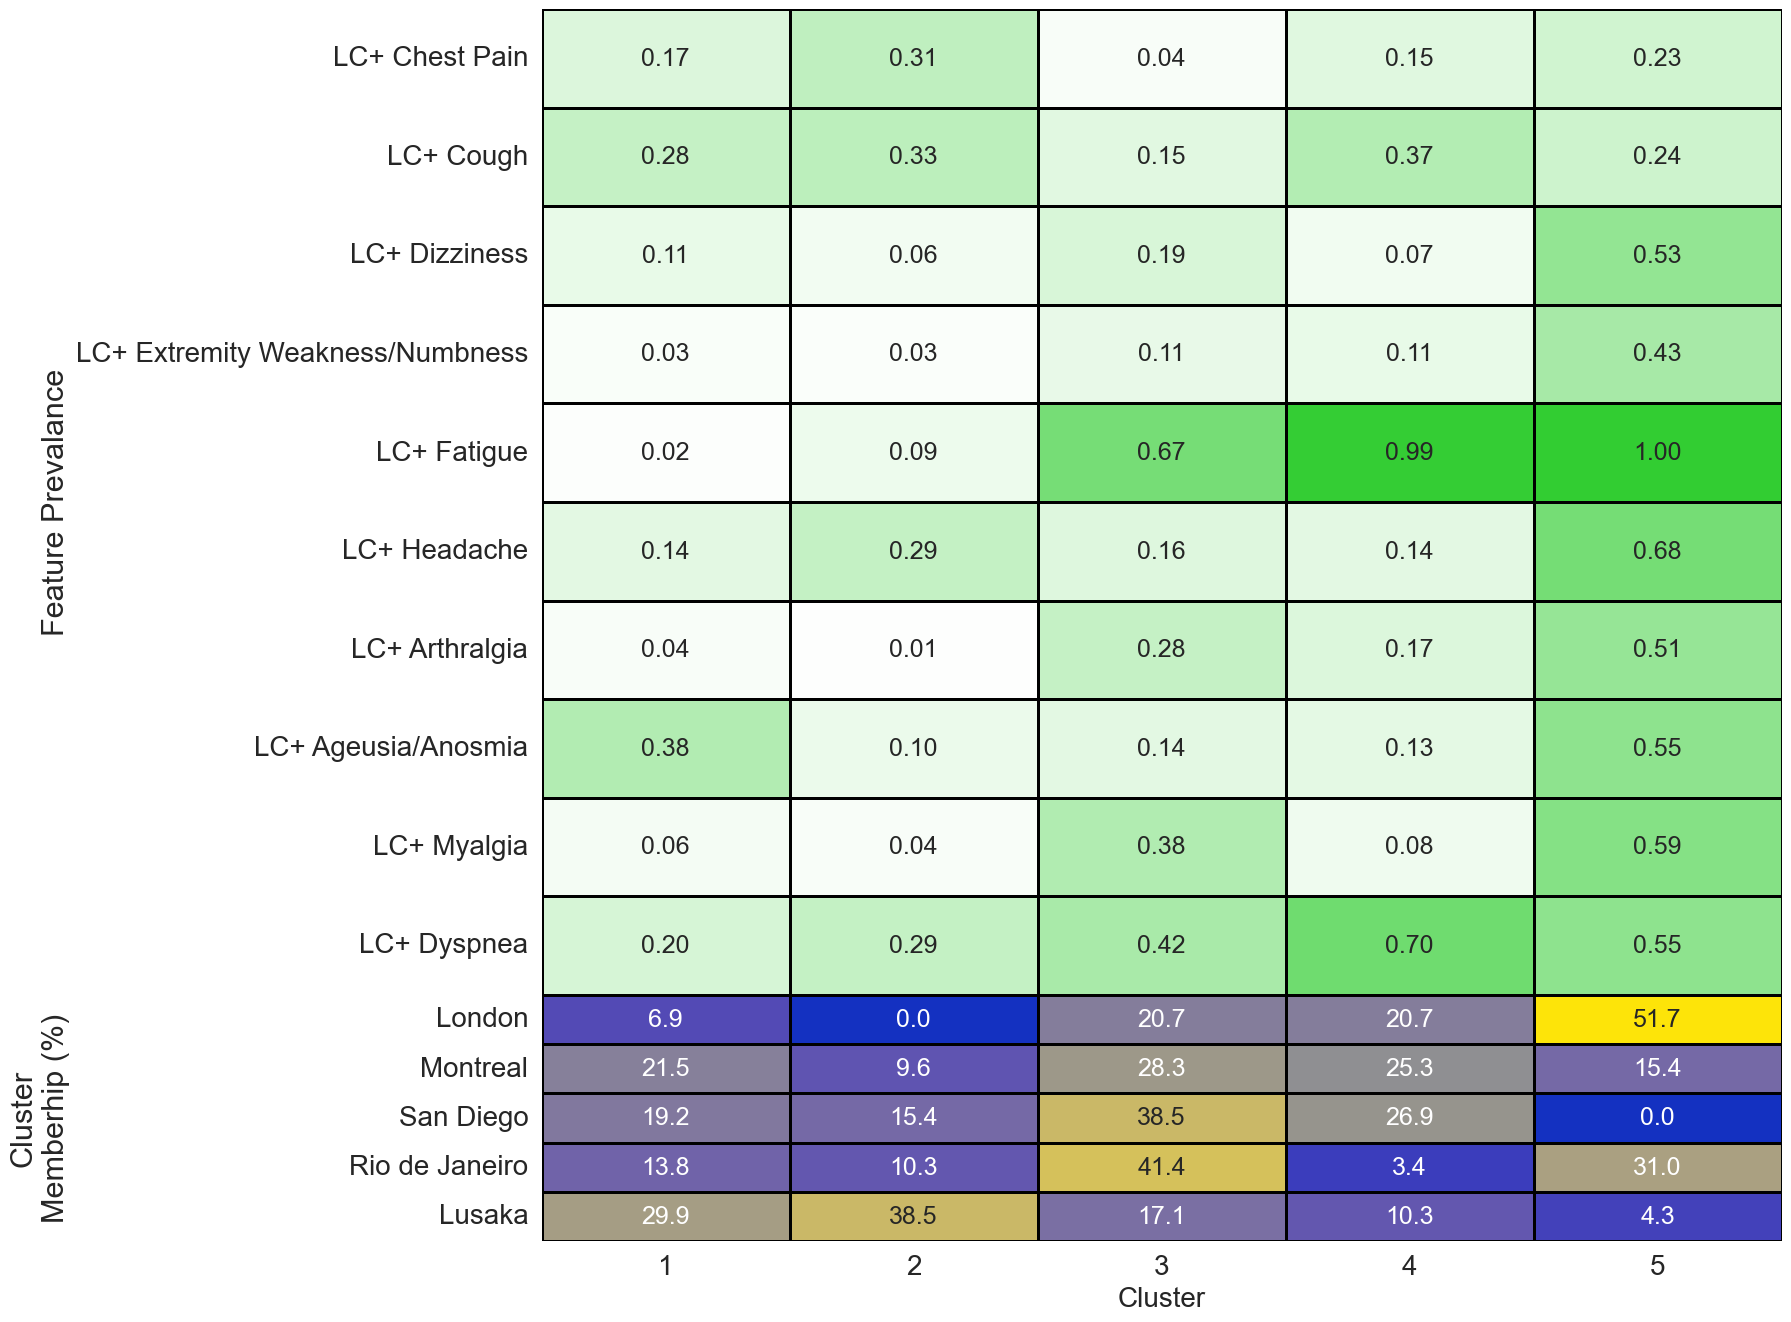

In [198]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(16,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

# from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]) 
axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure

for dpi in [300]:
    fn = f"{figdir}/lc-1028-SYMPT-feature-prevalence-by-cluster-{n_clust}-{dpi}-{timestamp}.png"
    print(fn)
    if SAVE:
        plt.savefig(fn, dpi = dpi, bbox_inches = 'tight')


# plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-600-{n_clust}.png", dpi = 600, bbox_inches = 'tight')
# plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-300-{n_clust}.png", dpi = 300, bbox_inches = 'tight')

# picle mfv
# mfv.to_pickle("./SYMPT_2-only-feature-prevalence-by-cluster.pkl")
